### Package Imports

In [14]:
import pandas as pd
import csv
import os
import gzip
import random
from collections import defaultdict
import math
import numpy as np

## 1. Describe the Dataset

Dataset download link: https://cseweb.ucsd.edu/~jmcauley/datasets.html#multi_aspect

In [151]:
import os
import gzip
import csv
import random

def json_to_csv(input_file, output_file_train, output_file_validation, output_file_test):
    """
    Converts a JSON-like file (or a .gz file containing JSON-like data) with dictionaries on each line into
    train, validation, and test CSV files, with a random split in an 8:1:1 ratio.

    Args:
        input_file (str): Path to the input JSON-like or .gz file.
        output_file_train (str): Path to the output CSV file for training data.
        output_file_validation (str): Path to the output CSV file for validation data.
        output_file_test (str): Path to the output CSV file for test data.
    """
    # Check if any output file already exists
    for output_file in [output_file_train, output_file_validation, output_file_test]:
        if os.path.exists(output_file):
            print(f"CSV file '{output_file}' already exists. Skipping conversion.")
            return

    data = []
    try:
        # Open the input file
        open_file = gzip.open if input_file.endswith('.gz') else open

        with open_file(input_file, 'rt', encoding='utf-8') as file:
            for i, line in enumerate(file):
                if i >= 220000:  # Limit to the first 220,000 lines
                    break
                try:
                    line = line.strip().rstrip(',')  # Remove whitespace and trailing commas
                    entry = eval(line)  # Safely parse the line as a dictionary
                    data.append(entry)  # Add the dictionary to the data list
                except Exception as e:
                    print(f"Error parsing line {i+1}: {line} -> {e}")

        # Shuffle the data
        random.shuffle(data)

        # Split the data into train, validation, and test sets
        train_size = int(0.8 * len(data))
        val_size = int(0.1 * len(data))

        train_data = data[:train_size]
        validation_data = data[train_size:train_size + val_size]
        test_data = data[train_size + val_size:]

        # Helper function to write data to a CSV file
        def write_to_csv(output_file, dataset):
            with open(output_file, 'w', newline='', encoding='utf-8') as csv_file:
                writer = csv.writer(csv_file)

                # Write header
                header = dataset[0].keys()
                writer.writerow(header)

                # Write rows
                for row in dataset:
                    writer.writerow(row.values())

        # Write the datasets to their respective CSV files
        if train_data:
            write_to_csv(output_file_train, train_data)
            print(f"Training data successfully written to {output_file_train}.")
        if validation_data:
            write_to_csv(output_file_validation, validation_data)
            print(f"Validation data successfully written to {output_file_validation}.")
        if test_data:
            write_to_csv(output_file_test, test_data)
            print(f"Test data successfully written to {output_file_test}.")
    except Exception as e:
        print(f"Error processing file: {e}")

# Example usage
input_file = 'ratebeer.json'
output_file_train = 'ratebeer_train.csv'
output_file_validation = 'ratebeer_validation.csv'
output_file_test = 'ratebeer_test.csv'

json_to_csv(input_file, output_file_train, output_file_validation, output_file_test)

CSV file 'ratebeer_train.csv' already exists. Skipping conversion.


In [139]:
input_file = 'ratebeer.json'
output_file_train = 'ratebeer_train.csv'
output_file_validation = 'ratebeer_validation.csv'
output_file_test = 'ratebeer_test.csv'

json_to_csv(input_file, output_file_train, 0, 180000)
json_to_csv(input_file, output_file_validation, 180000, 200000)
json_to_csv(input_file, output_file_test, 200000, 220000)

CSV file 'ratebeer_train.csv' already exists. Skipping conversion.
CSV file 'ratebeer_validation.csv' already exists. Skipping conversion.
CSV file 'ratebeer_test.csv' already exists. Skipping conversion.


If we convert the entire dataset into a csv file, the resulting file will be too large, thus we have decide to only use the first 20,000 samples for our project.

### Loading the dataset

In [152]:
df = pd.read_csv('ratebeer_train.csv')
df.head()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
0,Tyranena Three Beaches Honey Blonde Ale,50987,663,-,Golden Ale/Blond Ale,5/5,7/10,2/5,6/10,7/20,1316131200,Vir4030,Light yellow clear pour with a good head. Swee...
1,Dum t&#283;pn Klasicky Cesky Lek,66006,3587,5,Bohemian Pilsener,3/5,7/10,4/5,7/10,14/20,1217635200,Svesse,"(Draught at Pivovarsky Klub, Prague, 19 July 2..."
2,Steenbrugge Blond,85695,670,6.5,Belgian Ale,3/5,6/10,3/5,6/10,10/20,1271808000,Miksu,0.33 l bottle from Alko. Golden color. Sweet s...
3,Chimay Bleue &#40;Blue&#41; / Grande Rserve,53,12,9,Belgian Strong Ale,4/5,3/10,2/5,2/10,5/20,1269820800,Kieran_H,Really didnt like this beer. Been drinking a l...
4,Batemans Dragons Den,102091,806,4.1,Bitter,3/5,6/10,3/5,6/10,14/20,1240012800,cgarvieuk,Cask at Counting house Dundee (JDW) in Spoons ...


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176000 entries, 0 to 175999
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   beer/name           176000 non-null  object
 1   beer/beerId         176000 non-null  object
 2   beer/brewerId       176000 non-null  int64 
 3   beer/ABV            176000 non-null  object
 4   beer/style          176000 non-null  object
 5   review/appearance   176000 non-null  object
 6   review/aroma        176000 non-null  object
 7   review/palate       176000 non-null  object
 8   review/taste        176000 non-null  object
 9   review/overall      176000 non-null  object
 10  review/time         176000 non-null  int64 
 11  review/profileName  176000 non-null  object
 12  review/text         175817 non-null  object
dtypes: int64(2), object(11)
memory usage: 17.5+ MB


In [120]:
df.describe()

,beer/brewerId,review/time
count,176000.000000,1.760000e+05
mean,2237.488358,1.210000e+09
std,2988.823991,7.960769e+07
min,1.000000,9.564480e+08
25%,398.000000,1.157155e+09
50%,1158.000000,1.218413e+09
75%,3110.000000,1.276819e+09
max,13874.000000,1.326413e+09


In [155]:
df.isnull().sum()

beer/name               0
beer/beerId             0
beer/brewerId           0
beer/ABV                0
beer/style              0
review/appearance       0
review/aroma            0
review/palate           0
review/taste            0
review/overall          0
review/time             0
review/profileName      0
review/text           183
dtype: int64

In [122]:
num_beers = df['beer/beerId'].nunique()
print("No. of unique beers in train data: " + str(num_beers))

avg_reviews_per_beer = df.groupby('beer/beerId').size().mean()
print("Average no. of reviews per beer: " + str(avg_reviews_per_beer))

num_users = df['review/profileName'].nunique()
print("No. of unique users: " + str(num_users))

avg_reviews_per_user = df.groupby('review/profileName').size().mean()
print("Average no. of reviews per user: " + str(avg_reviews_per_user))

num_brewers = df['beer/brewerId'].nunique()
print("No. of unique breweries: " + str(num_brewers))

avg_reviews_per_brewer = df.groupby('beer/brewerId').size().mean()
print("Average no. of reviews per brewer: " + str(avg_reviews_per_brewer))

shape = df.shape

print(f"No. of rows: {shape[0]}")
print(f"No. of cols: {shape[1]}")

No. of unique beers in train data: 8863
Average no. of reviews per beer: 19.857835947196207
No. of unique users: 9072
Average no. of reviews per user: 19.400352733686066
No. of unique breweries: 636
Average no. of reviews per brewer: 276.7295597484277
No. of rows: 176000
No. of cols: 13


In [124]:
# outputting the types of the dataframe

print(train_df.dtypes)

beer/name               object
beer/beerId             object
beer/brewerId            int64
beer/ABV               float64
beer/style              object
review/appearance       object
review/aroma            object
review/palate           object
review/taste            object
review/overall         float64
review/time              int64
review/profileName      object
review/text             object
beer/ABV_normalized    float64
adjusted_rating        float64
dtype: object


In [125]:
# Check for duplicates
duplicates = train_df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate records: {num_duplicates}")

if num_duplicates > 0:
    print("\nDuplicate Records:")
    print(train_df[duplicates])
else:
    print("\nNo duplicate records found.")


Number of duplicate records: 0

No duplicate records found.


In [127]:
# Finding flagged reviews
flagged_reviews = (
    train_df.groupby('review/text')
    .agg(
        beer_count=('beer/beerId', 'nunique'),  
        user_count=('review/profileName', 'nunique')  
    )
    .reset_index()
)

flagged_reviews = flagged_reviews[flagged_reviews['beer_count'] > 3]
flagged_with_users = train_df.merge(flagged_reviews, on='review/text')
profile_names = flagged_with_users['review/profileName'].unique()
print("Profile names with flagged reviews:")
for name in profile_names:
    print(name)


Profile names with flagged reviews:
brewersspot
Quake1028
DasBierChef
drowland
bchlala
SuperDave
JediMindTricks
Brandman
camilla
kdheckle
dobrisa
iamsancho16


In [128]:
!pip install wordcloud

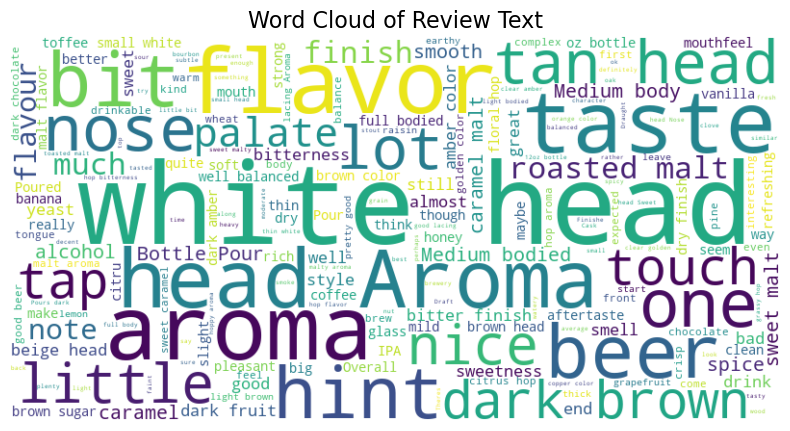

In [129]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all review text into a single string
text_data = ' '.join(review for review in train_df['review/text'].dropna())

# Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis',
    max_words=200
).generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Review Text", fontsize=16)
plt.show()


Average ratings by reviewer type:
reviewer_type
Occasional    14.396398
Prolific      13.399759
Name: review/overall, dtype: float64


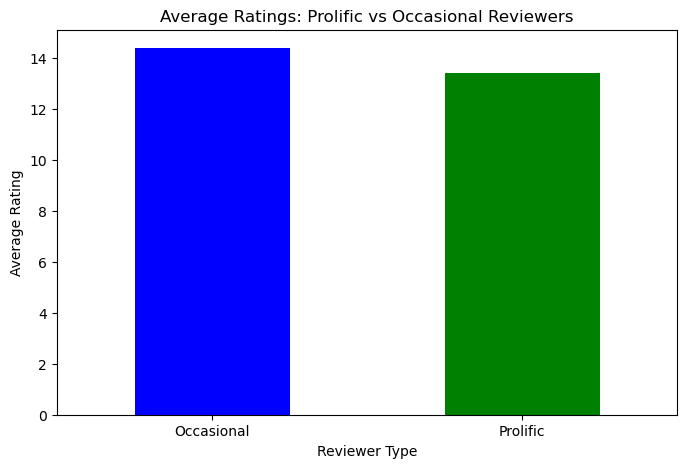

In [141]:
user_review_counts = train_df.groupby('review/profileName').size().reset_index(name='review_count')

train_df = train_df.merge(user_review_counts, on='review/profileName')

threshold = 10
train_df['reviewer_type'] = train_df['review_count'].apply(
    lambda x: 'Prolific' if x > threshold else 'Occasional'
)

average_ratings = train_df.groupby('reviewer_type')['review/overall'].mean()

print("Average ratings by reviewer type:")
print(average_ratings)

import matplotlib.pyplot as plt

average_ratings.plot(kind='bar', color=['blue', 'green'], figsize=(8, 5))
plt.title("Average Ratings: Prolific vs Occasional Reviewers")
plt.ylabel("Average Rating")
plt.xlabel("Reviewer Type")
plt.xticks(rotation=0)
plt.show()


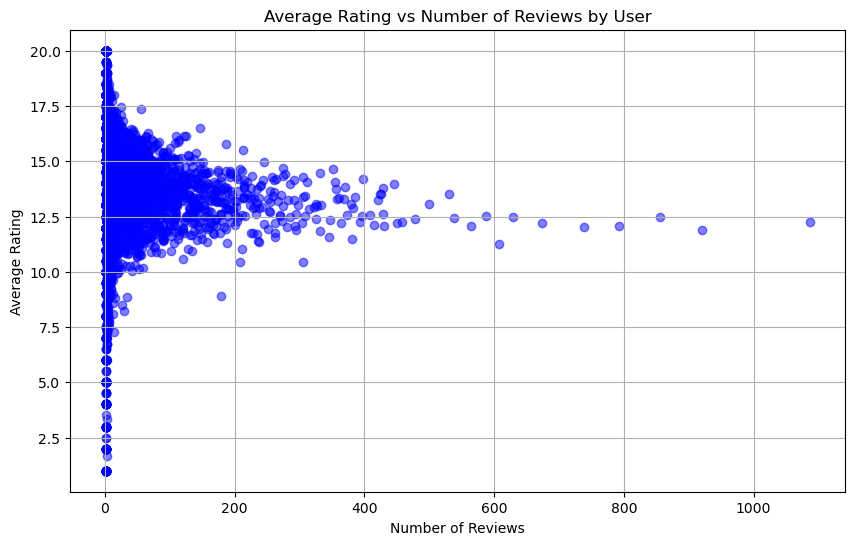

Correlation between number of reviews and average rating: -0.11


In [142]:
import matplotlib.pyplot as plt

# Step 1: Count total reviews per user
user_review_counts = train_df.groupby('review/profileName').size().reset_index(name='review_count')

# Step 2: Calculate average rating per user
user_avg_ratings = train_df.groupby('review/profileName')['review/overall'].mean().reset_index(name='avg_rating')

# Merge both into a single DataFrame
user_data = pd.merge(user_review_counts, user_avg_ratings, on='review/profileName')

# Step 3: Plot Average Rating vs Number of Reviews
plt.figure(figsize=(10, 6))
plt.scatter(user_data['review_count'], user_data['avg_rating'], alpha=0.5, color='b')
plt.title('Average Rating vs Number of Reviews by User')
plt.xlabel('Number of Reviews')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

# Optional: Calculate correlation between the two variables
correlation = user_data['review_count'].corr(user_data['avg_rating'])
print(f"Correlation between number of reviews and average rating: {correlation:.2f}")


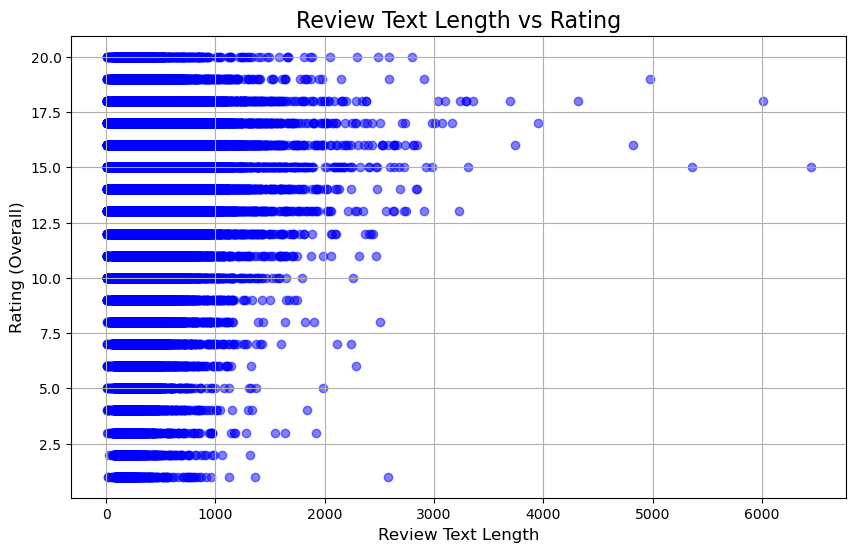

In [157]:
# scatter plot for rating vs text length

import matplotlib.pyplot as plt

train_df['review_text_length'] = train_df['review/text'].apply(lambda x: len(str(x)))
plt.figure(figsize=(10, 6))
plt.scatter(train_df['review_text_length'], train_df['review/overall'], alpha=0.5, color='b')
plt.title('Review Text Length vs Rating', fontsize=16)
plt.xlabel('Review Text Length', fontsize=12)
plt.ylabel('Rating (Overall)', fontsize=12)
plt.grid(True)
plt.show()


## 2. Identify a Predictive Task on our Dataset

For this dataset, our group decide to make a predictor for the overall rating of a beer, based on the text review of the users.


In [145]:
# !pip install textblob

# from sklearn import linear_model
# from textblob import TextBlob
# import numpy as np
# from csv import DictReader

# # Load training data
# trainData = []
# with open('ratebeer_train.csv', 'r') as f:
#     dict_reader = DictReader(f)
#     trainData = list(dict_reader)

# # Use library to get sentiment
# def feature(datum):
#     blob = TextBlob(datum['review/text'])
#     return blob.sentiment.polarity

# # Convert 'X/20' format to float
# def floatRating(datum):
#     return (float(datum['review/overall'].split('/')[0])*.05)

# # Train linear model
# polarities = [feature(d) for d in trainData]
# ratings = [floatRating(d) for d in trainData]

# X = np.array([[1,p] for p in polarities])
# Y = np.array(ratings).T

# model = linear_model.LinearRegression(fit_intercept=False)
# model.fit(X, Y)

# y_pred = np.array(model.predict(X))
# sse = sum([x**2 for x in (Y - y_pred)])
mse = sse / len(Y)

Error: line contains NUL

In [ ]:
# # Load validation set
# validationData = []
# with open('ratebeer_validation.csv', 'r') as f:
#     dict_reader = DictReader(f)
#     validationData = list(dict_reader)

# polarities = [feature(d) for d in validationData]
# ratings = [floatRating(d) for d in validationData]

# X = np.array([[1,p] for p in polarities])
# Y = np.array(ratings).T

# #Round predicition to nearest X/20
# # def roundPrediction(p):
# #     return round(p * 20) / 20

# y_pred = np.array(model.predict(X))
# sse = sum([x**2 for x in (Y - y_pred)])
# mse = sse / len(Y)
# print(mse)

# print(y_pred[:5])
# print(Y[:5])

0.015543805789271206
[0.64719316 0.76859969 0.6828643  0.70820972 0.68544715]
[0.65 0.75 0.55 0.65 0.85]


In [2]:
import gzip
import csv
from collections import defaultdict

def readCSV(path):
    with gzip.open(path, 'rb') as f:  
        clean_lines = (line.replace(b'\x00', b'') for line in f)  
        text_lines = (line.decode('utf-8', errors='ignore') for line in clean_lines)  
        reader = csv.reader(text_lines)  
        header = next(reader, None)  
        
        for fields in reader:
            if len(fields) < 13: 
                continue

            try:
                beer_name = fields[0]
                beer_id = fields[1]
                brewer_id = int(fields[2])
                beer_abv = fields[3]
                beer_style = fields[4]
                review_appearance = parse_rating(fields[5])
                review_aroma = parse_rating(fields[6])
                review_palate = parse_rating(fields[7])
                review_taste = parse_rating(fields[8])
                review_overall = parse_rating(fields[9])
                review_time = int(fields[10])
                review_profileName = fields[11]
                review_text = fields[12] if len(fields) > 12 else None

                yield {
                    "beer/name": beer_name,
                    "beer/beerId": beer_id,
                    "beer/brewerId": brewer_id,
                    "beer/ABV": beer_abv,
                    "beer/style": beer_style,
                    "review/appearance": review_appearance,
                    "review/aroma": review_aroma,
                    "review/palate": review_palate,
                    "review/taste": review_taste,
                    "review/overall": review_overall,
                    "review/time": review_time,
                    "review/profileName": review_profileName,
                    "review/text": review_text
                }
            except (ValueError, IndexError) as e:
                print(f"Error parsing row: {fields} -> {e}")
                continue

def parse_rating(rating):
    try:
        if '/' in rating:
            numerator, denominator = map(float, rating.split('/'))
            return numerator / denominator  
        return float(rating)
    except (ValueError, TypeError):
        return None  

path = 'train.csv.gz'
ratings = defaultdict(list)
entries = []  

for entry in readCSV(path):
    ratings[entry['review/profileName']].append(
        (entry['beer/beerId'], entry['review/overall'])
    )
    entries.append(entry)

In [7]:
from collections import defaultdict
import math

# Function to compute cosine similarity between two users
def cosine_similarity(user1_ratings, user2_ratings):
    common_books = set(book_id for book_id, _ in user1_ratings) & set(book_id for book_id, _ in user2_ratings)
    
    if not common_books:
        return 0 
    
    numerator = 0
    for book_id, score in user1_ratings:
        if book_id in common_books:
            user2_score = next(score2 for book2, score2 in user2_ratings if book2 == book_id)
            numerator += score * user2_score
    
    user1_magnitude = math.sqrt(sum(score**2 for _, score in user1_ratings if _ in common_books))
    user2_magnitude = math.sqrt(sum(score**2 for _, score in user2_ratings if _ in common_books))
    
    if user1_magnitude == 0 or user2_magnitude == 0:
        return 0 
    
    return numerator / (user1_magnitude * user2_magnitude)

user_similarities = defaultdict(dict)
count = 0
for user1 in ratings:
    count += 1
    for user2 in ratings:
        if user1 != user2:
            similarity = cosine_similarity(ratings[user1], ratings[user2])
            user_similarities[user1][user2] = similarity
        

9072
1
9072
2
9072
3
9072
4
9072
5
9072
6
9072
7
9072
8
9072
9
9072
10
9072
11
9072
12
9072
13
9072
14
9072
15
9072
16
9072
17
9072
18
9072
19
9072
20
9072
21
9072
22
9072
23
9072
24
9072
25
9072
26
9072
27
9072
28
9072
29
9072
30
9072
31
9072
32
9072
33
9072
34
9072
35
9072
36
9072
37
9072
38
9072
39
9072
40
9072
41
9072
42
9072
43
9072
44
9072
45
9072
46
9072
47
9072
48
9072
49
9072
50
9072
51
9072
52
9072
53
9072
54
9072
55
9072
56
9072
57
9072
58
9072
59
9072
60
9072
61
9072
62
9072
63
9072
64
9072
65
9072
66
9072
67
9072
68
9072
69
9072
70
9072
71
9072
72
9072
73
9072
74
9072
75
9072
76
9072
77
9072
78
9072
79
9072
80
9072
81
9072
82
9072
83
9072
84
9072
85
9072
86
9072
87
9072
88
9072
89
9072
90
9072
91
9072
92
9072
93
9072
94
9072
95
9072
96
9072
97
9072
98
9072
99
9072
100
9072
101
9072
102
9072
103
9072
104
9072
105
9072
106
9072
107
9072
108
9072
109
9072
110
9072
111
9072
112
9072
113
9072
114
9072
115
9072
116
9072
117
9072
118
9072
119
9072
120
9072
121
9072
122
9072
123
9

In [24]:
path = 'train.csv.gz'

ratingsByUser = defaultdict(list)
entries = []  
ratingsByBeer = defaultdict(list)
userItemRatings = defaultdict(dict)
for entry in readCSV(path):
    ratingsByUser[entry['review/profileName']].append(
        (entry['beer/beerId'], entry['review/overall'])
    )
    ratingsByBeer[entry['beer/beerId']].append(
        (entry['review/profileName'], entry['review/overall']) 
    )
    userItemRatings[entry['review/profileName']][entry['beer/beerId']] = entry['review/overall']
    entries.append(entry)

path = 'validation.csv.gz'
entriesVal = []  

for entry in readCSV(path):
    entriesVal.append(entry)

0.35


In [34]:
# cosine similarity based approach

y = []
for entry in entriesVal:
    y.append(entry['review/overall'])

y_pred = []
for entry in entriesVal:
    numerator = 0
    denominator = 0
    target_user = entry['review/profileName']
    target_beer = entry['beer/beerId']
    
    for user, userRating in ratingsByBeer[entry['beer/beerId']]:
        if user != target_user:
            if target_user in user_similarities and user in user_similarities[target_user]:
                similarity = user_similarities[target_user][user]
                
                if target_beer in userItemRatings[user]:
                    userRating = userItemRatings[user][target_beer]
                    numerator += similarity * userRating
                    denominator += abs(similarity)

    predicted_rating = numerator / denominator if denominator != 0 else 0
    y_pred.append(predicted_rating)


In [39]:
import numpy as np

mse = np.mean((np.array(y) - np.array(y_pred)) ** 2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.027009289464989258


In [ ]:
import numpy as np

mse = np.mean((np.array(y) - np.array(y_pred)) ** 2)
print(f"Mean Squared Error: {mse}")

In [42]:
def pearson_similarity(user1_ratings, user2_ratings):
    common_books = set(book_id for book_id, _ in user1_ratings) & set(book_id for book_id, _ in user2_ratings)
    if not common_books:
        return 0 
    user1_common = [score for book_id, score in user1_ratings if book_id in common_books]
    user2_common = [score for book_id, score in user2_ratings if book_id in common_books]
    mean_user1 = sum(user1_common) / len(user1_common)
    mean_user2 = sum(user2_common) / len(user2_common)
    numerator = sum((score1 - mean_user1) * (score2 - mean_user2) for score1, score2 in zip(user1_common, user2_common))
    denominator1 = sum((score1 - mean_user1) ** 2 for score1 in user1_common)
    denominator2 = sum((score2 - mean_user2) ** 2 for score2 in user2_common)
    
    denominator = (denominator1 ** 0.5) * (denominator2 ** 0.5)
    if denominator == 0:
        return 0
    
    return numerator / denominator

user_pearson_similarities = defaultdict(dict)
count = 0
for user1 in ratings:
    count += 1
    for user2 in ratings:
        if user1 != user2:
            similarity = cosine_similarity(ratings[user1], ratings[user2])
            user_pearson_similarities[user1][user2] = similarity


9072
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

In [53]:
# pearson similarity based approach
import math

y = []
for entry in entriesVal:
    y.append(entry['review/overall'])

def average_rating(user):
    ratings = [rating for beerId, rating in userItemRatings[user].items()]
    return sum(ratings) / len(ratings) if ratings else 0
y_pred = []
count = 0
for entry in entriesVal:
    count += 1
    numerator = 0
    denominator = 0
    target_user = entry['review/profileName']
    target_beer = entry['beer/beerId']

    for user, userRating in ratingsByBeer[entry['beer/beerId']]:
        if user != target_user:
            if target_user in user_pearson_similarities and user in user_pearson_similarities[target_user]:
                similarity = user_pearson_similarities[target_user][user]
                if target_beer in userItemRatings[user]:
                    userRating = userItemRatings[user][target_beer]
                    
                    numerator += similarity * (userRating - average_rating(user))
                    denominator += abs(similarity)

    target_user_avg_rating = average_rating(target_user)
    predicted_rating = target_user_avg_rating + (numerator / denominator if denominator != 0 else 0)
    y_pred.append(predicted_rating)

22000
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

In [54]:
import numpy as np

mse = np.mean((np.array(y) - np.array(y_pred)) ** 2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.021911746189569363


In [113]:
# print(entries[1])

{'beer/name': 'Dum t&#283;pn Klasicky Cesky Lek', 'beer/beerId': '66006', 'beer/brewerId': 3587, 'beer/ABV': '5', 'beer/style': 'Bohemian Pilsener', 'review/appearance': 0.6, 'review/aroma': 0.7, 'review/palate': 0.8, 'review/taste': 0.7, 'review/overall': 0.7, 'review/time': 1217635200, 'review/profileName': 'Svesse', 'review/text': '(Draught at Pivovarsky Klub, Prague, 19 July 2008, labeled "Stepan Nefiltrovany Svetly Lezak") Golden colour with frothy, white head. Malty, grassy nose with notes of hay and toffee. Malty, clean, fresh taste with hints of grass and a citric bitterness in the finish. Nicely balanced, but lacking the hop punch of the other Dum Svetly (couldnt really figure out the distinction between them since that one also seemed very unfiltered to me). Nice pilsener.'}


In [118]:
# incorporating ABV

import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

train_df = pd.read_csv('ratebeer_train.csv')

# Convert ratings from "X/Y" format to a float
def convert_rating(rating):
    try:
        numerator, denominator = map(float, rating.split('/'))
        return numerator  # Keep it on the original scale (e.g., 1-20)
    except ValueError:
        return None

# Apply the conversion function to the 'review/overall' column
train_df['review/overall'] = train_df['review/overall'].apply(convert_rating)

# Drop any rows with invalid ratings
train_df = train_df.dropna(subset=['review/overall'])

# Prepare data for Surprise library
reader = Reader(rating_scale=(1, 20))
data = Dataset.load_from_df(train_df[['review/profileName', 'beer/beerId', 'review/overall']], reader)

# Train SVD model
trainset, testset = train_test_split(data, test_size=0.1)
svd_model = SVD()
svd_model.fit(trainset)

# Predict ratings on the validation set
predictions = svd_model.test(testset)

# Calculate Mean Squared Error
mse = accuracy.mse(predictions)
print(f"SVD Model Mean Squared Error: {mse}")

print("\nComparison of Actual vs Predicted Ratings:")
print("User ID | Beer ID | Actual Rating | Predicted Rating")
for i, prediction in enumerate(predictions[:10]):  # Print only the first 10 predictions
    user_id = prediction.uid
    item_id = prediction.iid
    actual_rating = prediction.r_ui
    predicted_rating = prediction.est
    print(f"{user_id} | {item_id} | {actual_rating:.2f} | {predicted_rating:.2f}")

MSE: 4.9539
SVD Model Mean Squared Error (with ABV adjustment): 4.953918313398594

Comparison of Actual vs Predicted Ratings:
User ID | Beer ID | Actual Rating | Predicted Rating
Pastor | 2529 | 14.00 | 14.97
Storm | 43091 | 17.94 | 18.01
mxtur | 29449 | 11.06 | 14.35
IrishBoy | 29343 | 14.63 | 13.21
blankboy | 11380 | 13.76 | 14.13
Bockyhorsey | 19726 | 11.71 | 12.48
willblake | 11363 | 14.54 | 14.93
turbo | 48498 | 15.58 | 18.95
Dfonorow | 84022 | 15.36 | 15.61
lusikka | 6378 | 10.68 | 11.14
